### Analysis of Buttons Bandit

In [109]:
# Run this script to add the src directory to the python path

from notebook_utils import modify_sys_path, get_src_dir_path

modify_sys_path()

In [110]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cm import get_cmap
import numpy as np
import re
from csaps import csaps
from scipy.interpolate import UnivariateSpline

from src.bandit import ButtonsBandit

In [159]:
# results_directory = 'results/logistic_regression_3/experiment_2/active_learning/dataset_specified/'

exploration_rate = 2

# results_directory = f'results/bandits/buttons/exploration_ucb1_{exploration_rate}/'
results_directory = f'results/bandits/buttons/qwen14b/experiment_2/exploration_tv_{exploration_rate}/'

seed = 0

# results_directory = f'results/bandits/buttons_regression/test_reg/'

# run_name = f"exp_{exploration_rate}_ucb1_seed_{seed}.csv"
run_name = f"exp_{exploration_rate}_tv_seed_{seed}.csv"

# run_name = f"test_bandit_run.csv"

In [160]:
D_data = None

for filename in os.listdir(get_src_dir_path(results_directory)):
    if f"D_{run_name}" in filename:
        D_data = pd.read_csv(get_src_dir_path(results_directory) + filename)
        
        # Compute cumulative label

        D_data['cum_reward'] = D_data['label'].cumsum()
        D_data['cum_regret'] = D_data['regret'].cumsum()

Text(0.5, 1.0, 'Cumulative Reward over Trials')

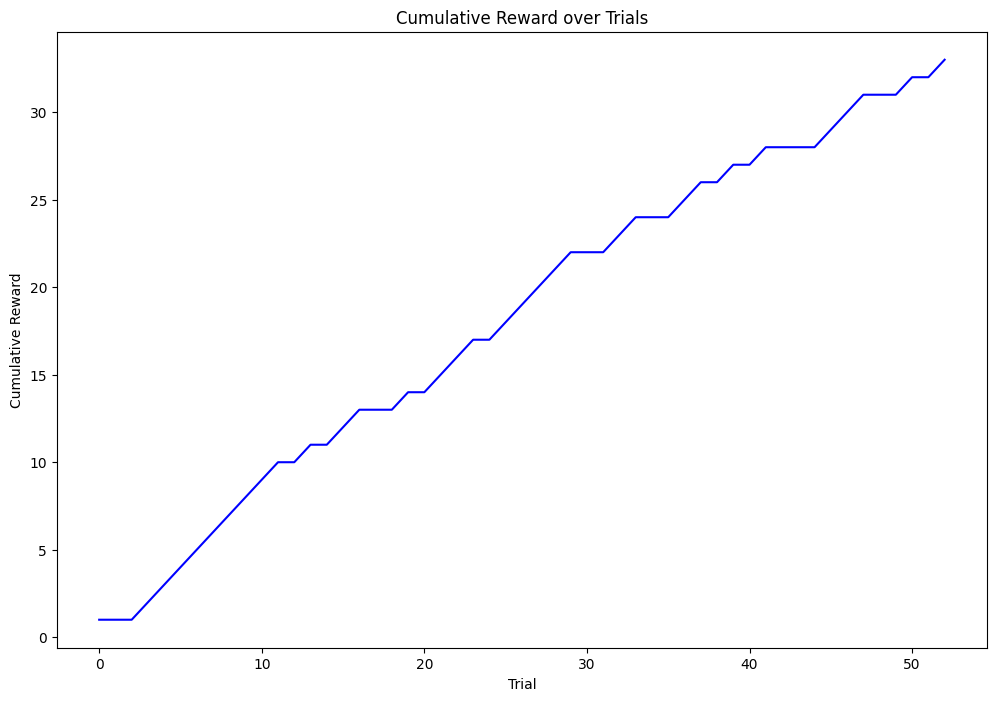

In [161]:
# plot cumulative reward against trials
plt.figure(figsize=(12, 8))
plt.plot(D_data['trial'], D_data['cum_reward'], label='Cumulative Reward', color='blue')
plt.xlabel('Trial')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward over Trials')

Text(0.5, 1.0, 'Cumulative Regret over Trials')

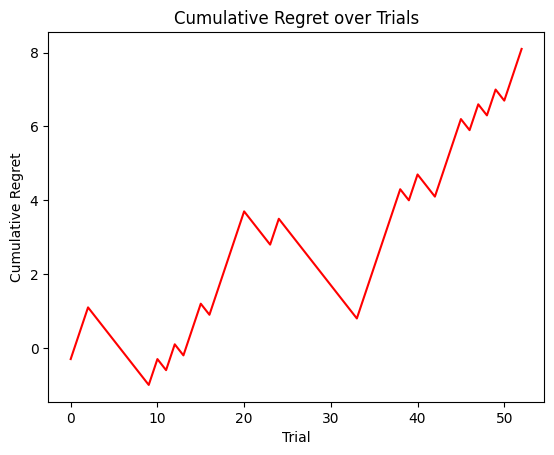

In [153]:
plt.plot(D_data['trial'], D_data['cum_regret'], label='Cumulative Regret', color='red')
plt.xlabel('Trial')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret over Trials')

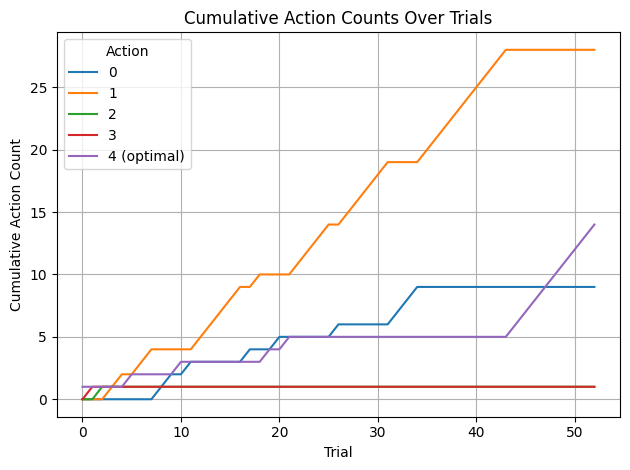

In [162]:
# Plot action counts over trials for each arm

action_counts = D_data.groupby(['trial', 'action']).size().unstack(fill_value=0)

# Sort by trial to ensure proper cumulative sum
action_counts = action_counts.sort_index()

# Cumulative sum over trials
cumulative_counts = action_counts.cumsum()

optimal_action = D_data['optimal_action'].values[0]

# Rename optimal action column

renamed_cumulative_counts = cumulative_counts.rename(columns={optimal_action: f'{optimal_action} (optimal)'}, inplace=False)

# Plot cumulative action counts
renamed_cumulative_counts.plot()
plt.xlabel('Trial')
plt.ylabel('Cumulative Action Count')
plt.title('Cumulative Action Counts Over Trials')
plt.legend(title='Action')
plt.tight_layout()
plt.grid()
plt.show()

In [163]:
mean_reward = D_data["label"].mean()
median_reward = D_data["label"].median()

print(f"Mean reward: {mean_reward}")
print(f"Median reward: {median_reward}")

Mean reward: 0.6226415094339622
Median reward: 1.0


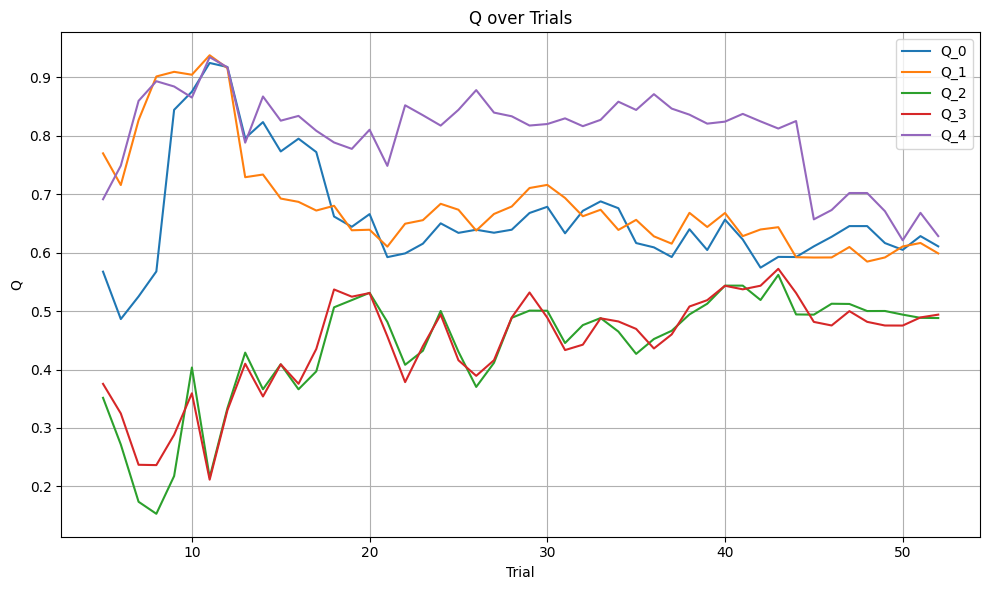

In [164]:
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(D_data['trial'], D_data[f'Q_value_{i}'], label=f'Q_{i}')

plt.xlabel('Trial')
plt.ylabel('Q')
plt.title('Q over Trials')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

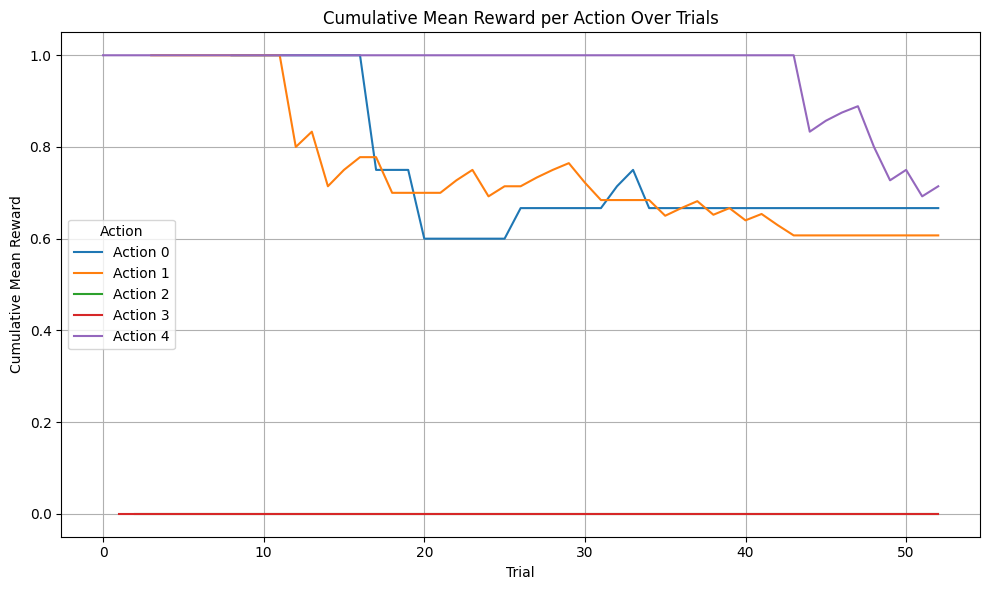

In [165]:
# plot mean cumulative reward per action
# Get list of all actions and trials
actions = D_data['action'].unique()
trials = D_data['trial'].unique()

# Initialize an empty list to collect results
records = []

# Initialize dicts to track cumulative reward and count for each action
cum_reward = {a: 0 for a in actions}
cum_count = {a: 0 for a in actions}

    
# Update cumulative sums for actions seen in this trial
for _, row in D_data.iterrows():
    t = row['trial']
    a = row['action']
    r = row['label']
    cum_reward[a] += r
    cum_count[a] += 1

    # For each action, compute cumulative mean so far
    for a in actions:
        if cum_count[a] > 0:
            mean = cum_reward[a] / cum_count[a]
        else:
            mean = np.nan
        records.append({'trial': t, 'action': a, 'cum_mean': mean})

# Create final DataFrame
df_cum_mean = pd.DataFrame(records)

plt.figure(figsize=(10, 6))

for action, group in df_cum_mean.groupby('action'):
    plt.plot(group['trial'], group['cum_mean'], label=f'Action {action}')

plt.xlabel('Trial')
plt.ylabel('Cumulative Mean Reward')
plt.title('Cumulative Mean Reward per Action Over Trials')
plt.legend(title='Action')
plt.grid(True)
plt.tight_layout()
plt.show()

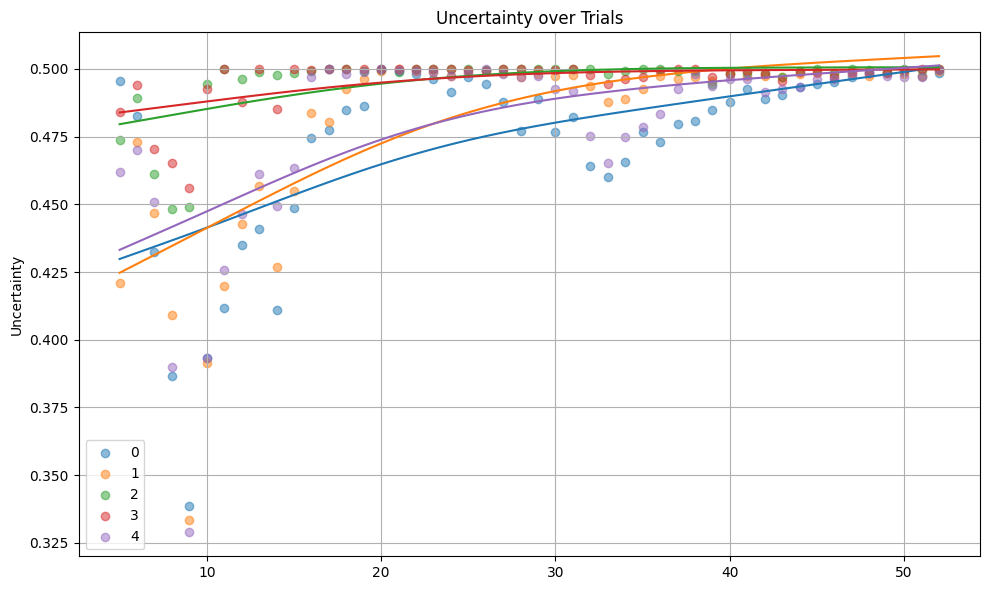

In [158]:
plt.figure(figsize=(10, 6))

actions = sorted(D_data['action'].unique())
cmap = plt.get_cmap('tab10')
colors = {action: cmap(i) for i, action in enumerate(actions)}

for action in actions:
    valid_indices = D_data[f'U_value_{action}'].notnull() & (D_data[f'U_value_{action}'] != 0) & (D_data[f'U_value_{action}'] < 100) 

    plt.scatter(D_data['trial'][valid_indices], D_data[f'U_value_{action}'][valid_indices], label=action, color=colors[action], alpha=0.5)    
    
    x_grid = np.linspace(D_data['trial'][valid_indices].min(), D_data[f'trial'].max(), 100)
    
    y_total_uncertainty = csaps(D_data['trial'][valid_indices], D_data[f'U_value_{action}'][valid_indices], smooth=0.0001)

    plt.plot(x_grid, y_total_uncertainty(x_grid), color = colors[action])


plt.ylabel('Uncertainty')
plt.title('Uncertainty over Trials')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

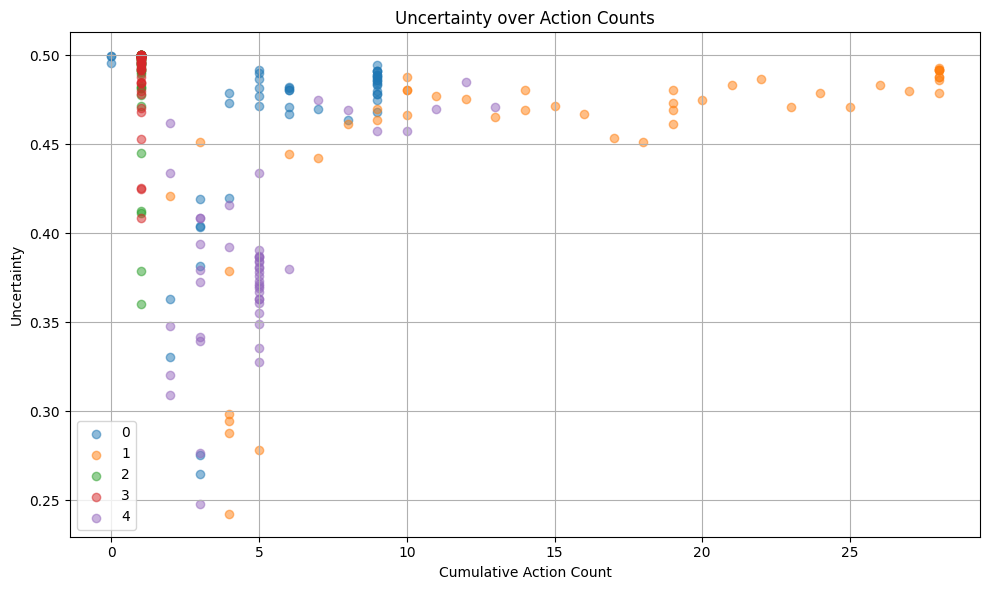

In [149]:
plt.figure(figsize=(10, 6))

actions = sorted(D_data['action'].unique())
cmap = plt.get_cmap('tab10')
colors = {action: cmap(i) for i, action in enumerate(actions)}

for action in actions:
    valid_indices = D_data[f'U_value_{action}'].notnull() & (D_data[f'U_value_{action}'] != 0) & (D_data[f'U_value_{action}'] < 100)
    
    plt.scatter(cumulative_counts[action][valid_indices], D_data[f'U_value_{action}'][valid_indices], label=action, color=colors[action], alpha=0.5)
     
    x_grid = np.linspace(cumulative_counts[action][valid_indices].min(), cumulative_counts[action][valid_indices].max(), 100)
    
    y_total_uncertainty = UnivariateSpline(cumulative_counts[action][valid_indices], D_data[f'U_value_{action}'][valid_indices], s=0.5)

    # plt.plot(x_grid, y_total_uncertainty(x_grid), color = colors[action])


plt.ylabel('Uncertainty')
plt.xlabel('Cumulative Action Count')
plt.title('Uncertainty over Action Counts')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<Axes: xlabel='action'>

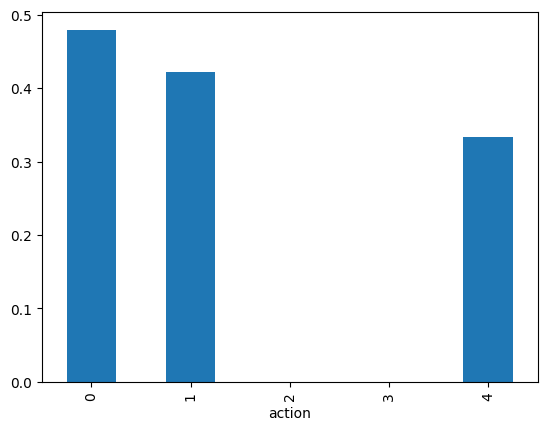

In [320]:
D_data.groupby('action')['label'].mean().plot(kind='bar')

#### Plotting over seeds

In [99]:
exploration_rate = 2

results_directory = f'results/bandits/buttons/exploration_ucb1_{exploration_rate}/'

seeds = list(range(5))


In [100]:
D_data_list = [None] * len(seeds)

for seed in seeds:
    run_name = f"exp_{exploration_rate}_ucb1_seed_{seed}.csv"
    for filename in os.listdir(get_src_dir_path(results_directory)):
        if f"D_{run_name}" in filename:
            D_data = pd.read_csv(get_src_dir_path(results_directory) + filename)
            
            # Compute cumulative label

            D_data['cum_reward'] = D_data['label'].cumsum()
            D_data['cum_regret'] = D_data['regret'].cumsum()
            
            D_data_list[seed] = D_data

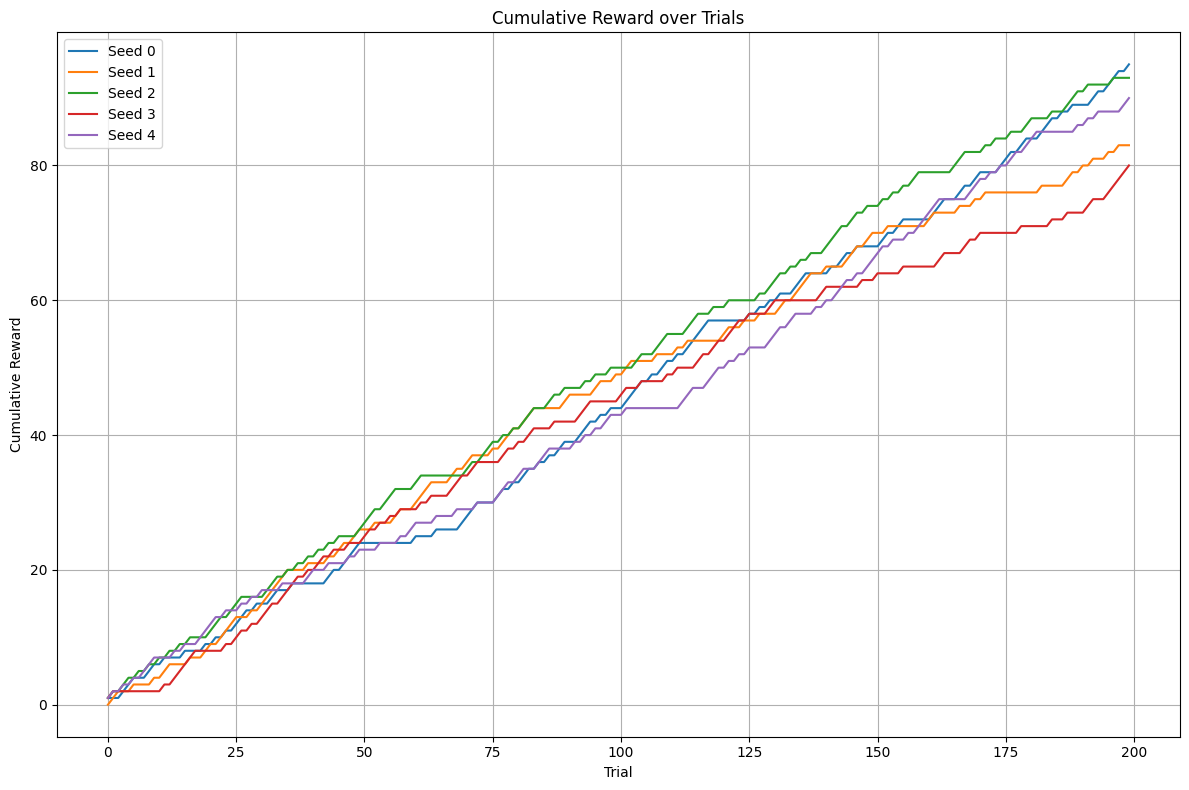

In [101]:
# plot cumulative reward against trials for each seed

plt.figure(figsize=(12, 8))
for seed in seeds:
    plt.plot(D_data_list[seed]['trial'], D_data_list[seed]['cum_reward'], label=f'Seed {seed}')
plt.xlabel('Trial')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward over Trials')
plt.legend()
plt.grid()
plt.tight_layout()

In [102]:
Trial_T = 100

cum_reward_list = []

for D_data in D_data_list:
    cum_reward_list.append(D_data.loc[D_data_list[0]['trial'] == Trial_T-1, 'cum_reward'].values[0])
    
median_reward = np.median(cum_reward_list)/Trial_T

mean_reward = np.mean(cum_reward_list)/Trial_T
std_reward = np.std(np.array(cum_reward_list)/Trial_T)
print(f"Mean reward at T={Trial_T}: {mean_reward}")
print(f"Std reward at T={Trial_T}: {std_reward}")
    
print(f"Median reward at T={Trial_T}: {np.median(cum_reward_list)/Trial_T}")

Mean reward at T=100: 0.462
Std reward at T=100: 0.027856776554368235
Median reward at T=100: 0.45


In [97]:
suffix_failure_count = 0

suffix_start = 50
suffix_end = 100

for D_data in D_data_list:
    optimal_action = D_data['optimal_action'].values[0]
    
    # is optimal action taken in between suffix_start and suffix_end
    
    action_taken = D_data.loc[(D_data['trial'] >= suffix_start) & (D_data['trial'] <= suffix_end), 'action'].values
    
    if optimal_action not in action_taken:
        suffix_failure_count += 1

suffix_fail_freq = suffix_failure_count / len(D_data_list)    

print("Suffix failure frequency (T/2): ", suffix_fail_freq)

Suffix failure frequency (T/2):  0.0


In [98]:
T = 100

K_min_action_freq_list = []

for D_data in D_data_list:
    # count the frequency of the action taken in the first T trials
    action_taken = D_data.loc[D_data['trial'] <= T, 'action'].values
    action_counts = {}
    for action in action_taken:
        if action not in action_counts:
            action_counts[action] = 0
        action_counts[action] += 1
    min_action_count = min(action_counts.values())
    num_actions = len(action_counts)
    min_action_freq = min_action_count / T
    K_min_action_freq = num_actions * min_action_freq
    K_min_action_freq_list.append(K_min_action_freq)
    
mean_K_min_action_freq = np.mean(K_min_action_freq_list)
print("Mean K_min_action_freq: ", mean_K_min_action_freq)

Mean K_min_action_freq:  1.0


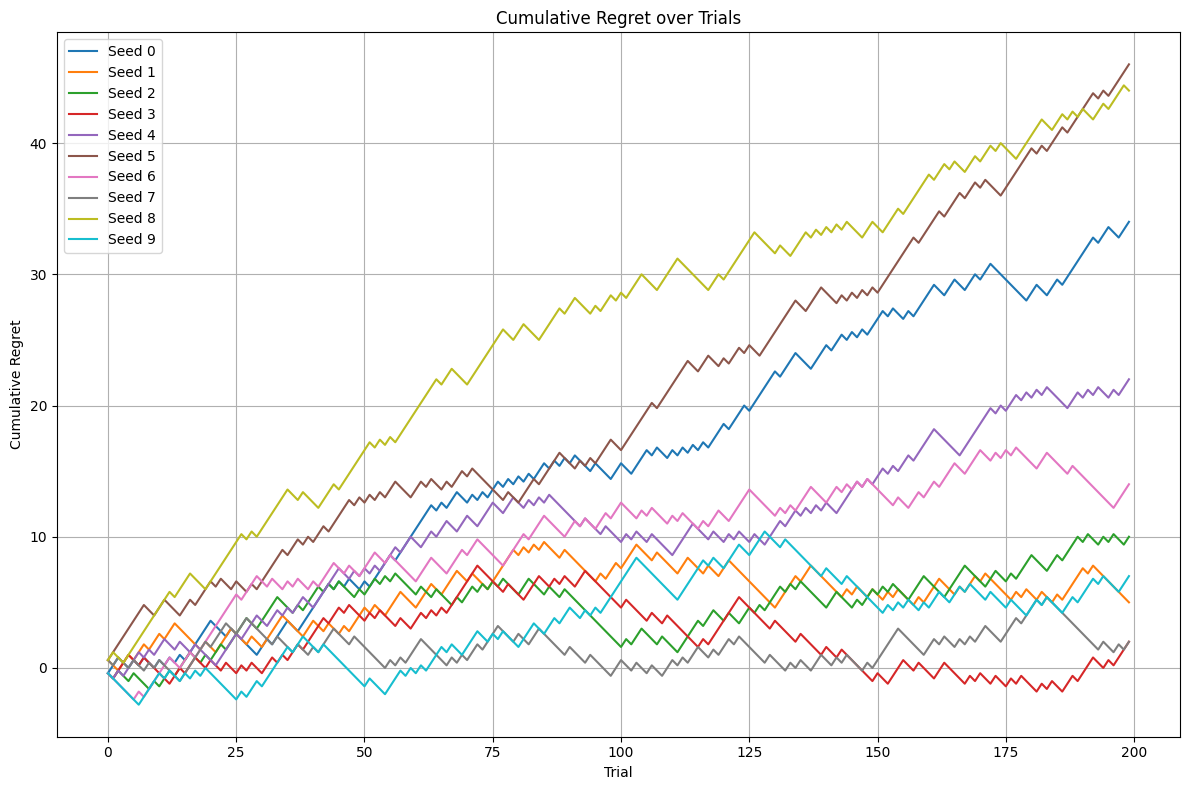

In [63]:
# plot cumulative regret against trials for each seed
plt.figure(figsize=(12, 8))
for seed in seeds:
    plt.plot(D_data_list[seed]['trial'], D_data_list[seed]['cum_regret'], label=f'Seed {seed}')
plt.xlabel('Trial')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret over Trials')
plt.legend()
plt.grid()
plt.tight_layout()